In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os


# Load the data

In [3]:
import os
train_normal_data_path = os.listdir('/content/drive/MyDrive/DEEP ASS LEARNING/Project/data/train/NORMAL')
train_pneumonia_data_path = os.listdir('/content/drive/MyDrive/DEEP ASS LEARNING/Project/data/train/PNEUMONIA')

print("Number of images in normal train set:", len(train_normal_data_path))
print("Number of images in pneumonia train set:", len(train_pneumonia_data_path))

Number of images in normal train set: 1341
Number of images in pneumonia train set: 3875


In [4]:
data_path = "/content/drive/MyDrive/DEEP ASS LEARNING/Project/data"
test = 'test'
train = 'train'
val = 'val' 

## First to transform the data

In [5]:
dataset = ImageFolder(data_path+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/drive/MyDrive/DEEP ASS LEARNING/Project/data/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

### Lets peek at an example image (in tensor form). All images are [3,224,224].

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.7176, 0.6353],
         [0.0000, 0.0000, 0.0000,  ..., 0.6902, 0.6824, 0.5608],
         [0.0000, 0.0000, 0.0000,  ..., 0.7059, 0.6000, 0.5294],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.7176, 0.6353],
         [0.0000, 0.0000, 0.0000,  ..., 0.6902, 0.6824, 0.5608],
         [0.0000, 0.0000, 0.0000,  ..., 0.7059, 0.6000, 0.5294],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.7176, 0.6353],
         [0.0000, 0.0000, 0.0000,  ..., 0.6902, 0.6824, 0.5608],
         [0.0000, 0.0000, 0.0000,  ..., 0.7059, 0.6000, 0.

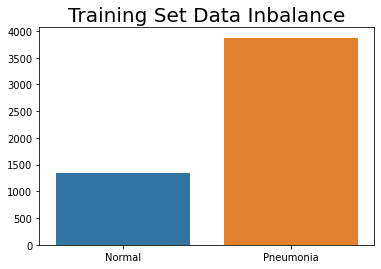

In [8]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_path+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

Label:  NORMAL (0)


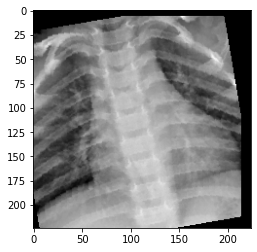

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

Lets plot some sample images

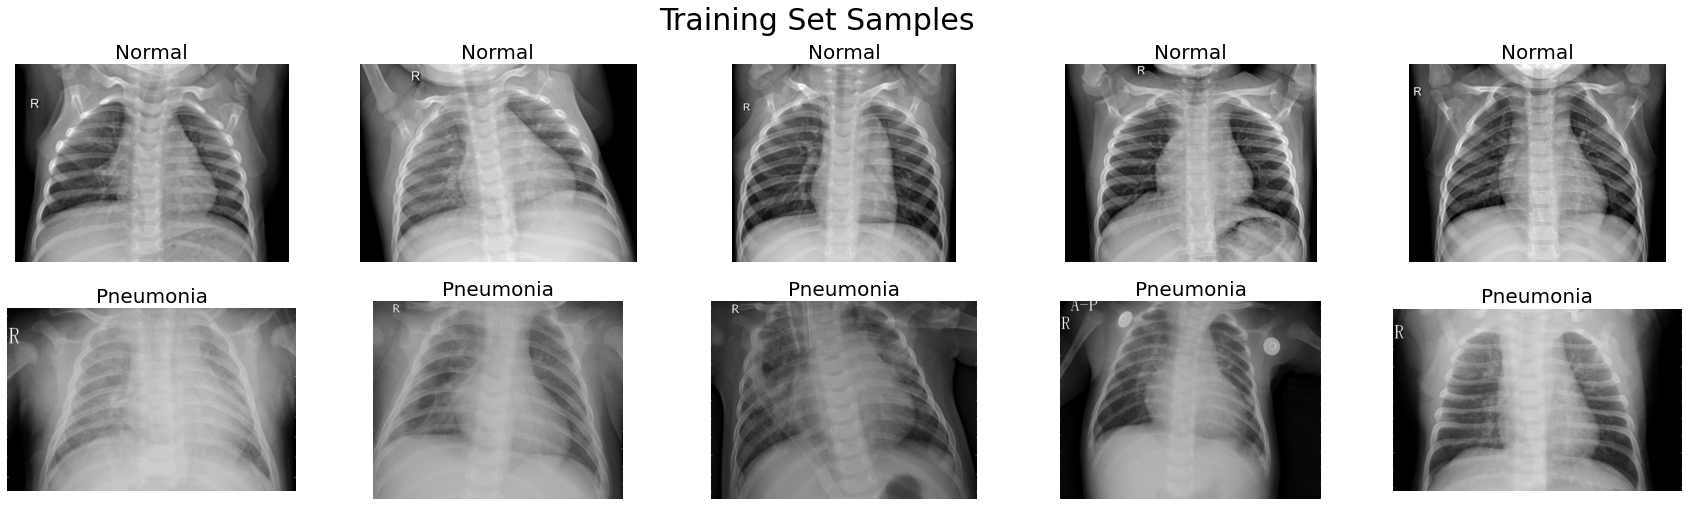

In [10]:
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')
rand_samples = random.sample([os.path.join(data_path+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

## Moving on to training, validation and the test data

First we must prepare and this is done through using random_split. Training set goes to 70/30 for training and validation

In [11]:
# set random seed so we get the same sampling every time for reproducibility
random_seed = 2020
torch.manual_seed(random_seed);

train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

Need to select batch size for mini_batch GD or optimizers. 

In [12]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
#Training on google colabs will most likely set this to false as very few gpu can be allocated freely
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

See if we can wrap the existing data loaders and move data to selected device, again if possible.

In [15]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Now for model creation!
Start by creating functions for calculating metrics of our model performance.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

### Now lets create the base model

In [17]:
class PneumoniaModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

### Now for the ResNet model
Since we focus on finetuning we use ResNet50 as a suitable pretrained model.
It has 48 convolutional layers along with 1 maxpool and 1 average pool layer. Also it utilizes an adaptive layer called adaptive average pool which allows us to input images of any size.

In [18]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Now to load the ResNet50 and its pretrained weights.
Then to freeze starting layers of the network(not the fully connected one ofcourse) and replace the last layer with our ows as the output should only be 2 classes and the baseline for ResNet50 is 1000 classes.

In [19]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)
    
#     def freeze(self):
#         # To freeze the residual layers
#         for param in self.network.parameters():
#             param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True
    
#     def unfreeze(self):
#         # Unfreeze all layers
#         for param in self.network.parameters():
#             param.require_grad = True

Lets continue and define some helper fuinctions to fit and evaluate the model.

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
#    Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

#     Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
#   sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients  
            
#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

### Close to the finish
But before we train the model we need to make sure that the data and the models parameters are on the same device, with the function previously defined.

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

## Wooho lets get some training done!
Since colabs(which is where training will occur for us) is limited, we settle for a modest number of epochs.

In [22]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], train_loss: 0.1502, train_acc: 0.9441, val_loss: 0.5003, val_acc: 0.8309
Epoch [2], train_loss: 0.0809, train_acc: 0.9720, val_loss: 0.0979, val_acc: 0.9632
Epoch [3], train_loss: 0.0551, train_acc: 0.9801, val_loss: 0.0767, val_acc: 0.9671
Epoch [4], train_loss: 0.0964, train_acc: 0.9738, val_loss: 0.0662, val_acc: 0.9731
Epoch [5], train_loss: 0.0712, train_acc: 0.9768, val_loss: 0.1334, val_acc: 0.9500
Epoch [6], train_loss: 0.0572, train_acc: 0.9817, val_loss: 0.2070, val_acc: 0.9448
Epoch [7], train_loss: 0.0631, train_acc: 0.9784, val_loss: 0.1115, val_acc: 0.9596
Epoch [8], train_loss: 0.0671, train_acc: 0.9733, val_loss: 0.0709, val_acc: 0.9704
Epoch [9], train_loss: 0.0382, train_acc: 0.9855, val_loss: 0.0909, val_acc: 0.9629
Epoch [10], train_loss: 0.0494, train_acc: 0.9846, val_loss: 0.0880, val_acc: 0.9654


In [ ]:
print('Best loss is:', best_loss)

Best loss is: 0.06669795513153076


If we want to save the model

In [ ]:
# Save Model
bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, '/content/drive/MyDrive/DEEP ASS LEARNING/Project/PneumoniaResnet.pth')

And if we want to load a model

In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./PneumoniaResnet.pth')

We cant really say that much from the training itself so lets plot to see underfitting or overfittin

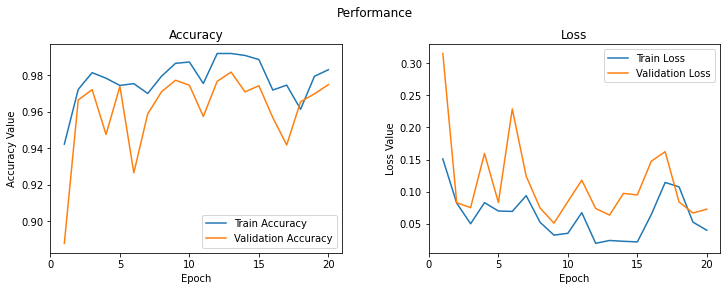

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Predictions

Now for some predictions. We want to have a baseline of how well the pre-trained model performs without fine-tuning and this will allow that as well.

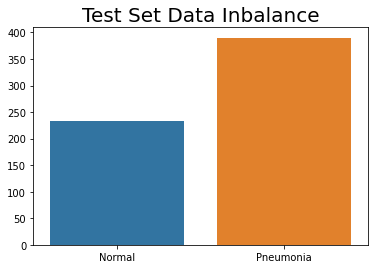

In [ ]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_path+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder(data_path+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [ ]:
# Evaluate test set

test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.3043, test_acc: 0.9128


## Evaluation?
How do we evaluate this in a meaningful way?
As usuall one must always keep the data in mind, and this data is clearly unbalanced. Thus pure accuracy is not necessarily the way to evaluate the model. It is probably better to look at precision and recall, as well as F1 score (harmonic mean).

<Figure size 432x288 with 0 Axes>

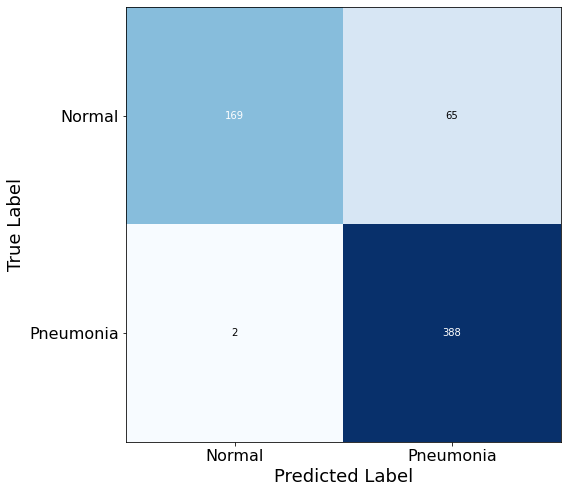

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.89
Recall of the model is 0.99
Precision of the model is 0.86
F1 Score of the model is 0.92


## Lets visualize some predictions better

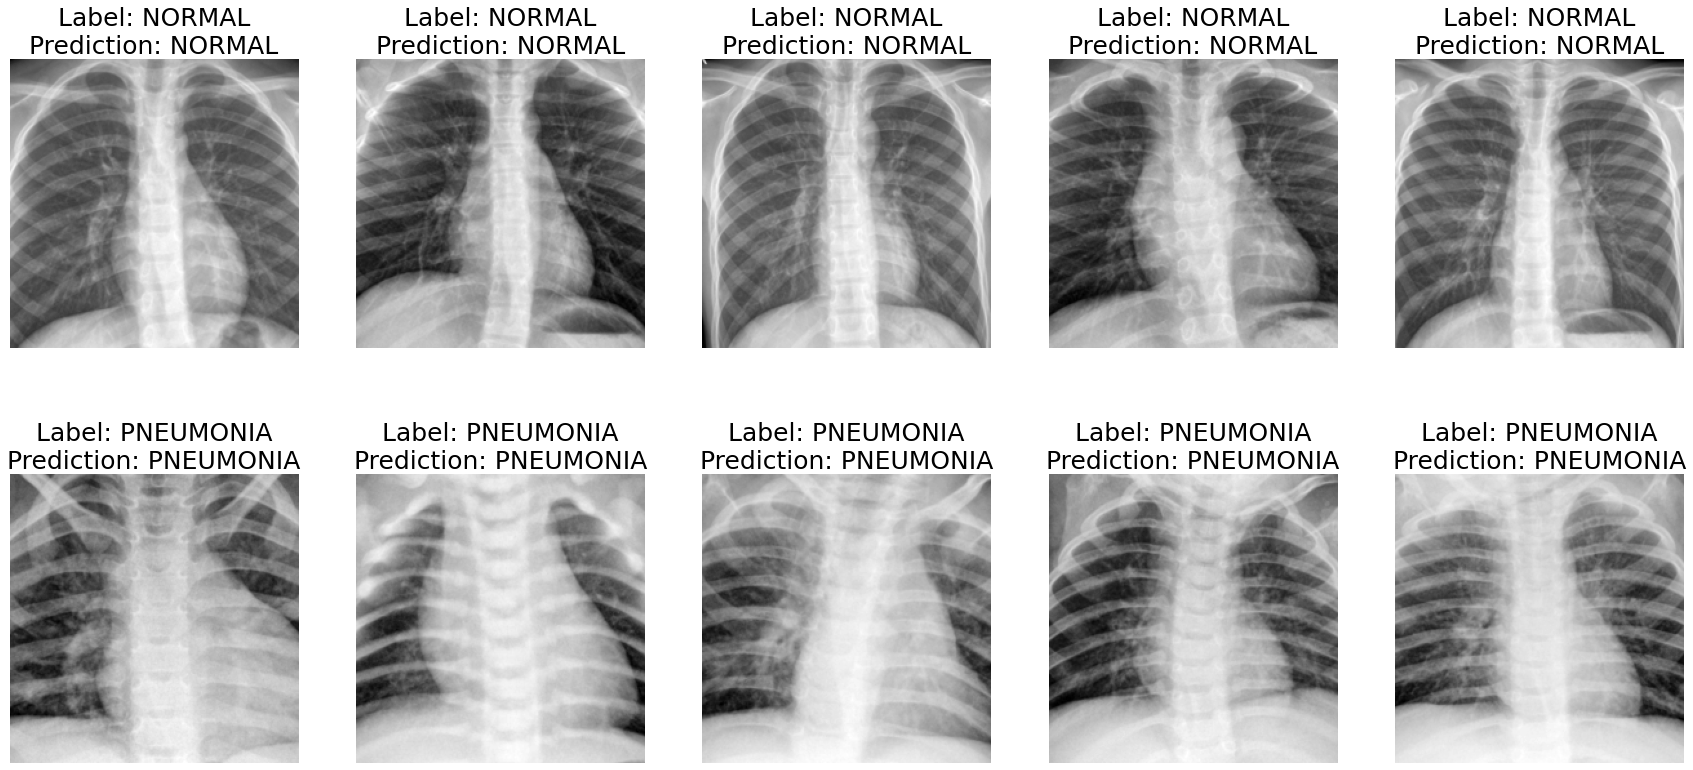

In [ ]:
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

In [ ]:
trainset = datasets.ImageFolder(os.path.join(data_path, train),transform = data_transforms(train))
testset = datasets.ImageFolder(os.path.join(data_path, test),transform = data_transforms(test))
validset = datasets.ImageFolder(os.path.join(data_path, val),transform = data_transforms(val))